In [1]:
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pywhy_graphs.viz import draw
import pymc as pm
from statsmodels.genmod.families.links import Logit
import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 1.0  # sets default credible interval used by arviz
warnings.filterwarnings('ignore')

1\. The data in data(NWOGrants) are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010–2012 (see van der Lee and Ellemers doi:10.1073/pnas.1510159112). These data have a structure similar to the UCBAdmit data discussed in Chapter 11 and in lecture. There are applications and each has an associated gender (of the lead researcher). But instead of departments, there are disciplines. Draw a DAG for this sample. Then use the backdoor criterion and a binomial GLM to estimate the TOTAL causal effect of gender on grant awards.

In [3]:
d = pd.read_csv("../../Data/NWOGrants.csv", sep=";", header=0)
d.head(10)

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18
5,Physics,f,9,2
6,Humanities,m,230,33
7,Humanities,f,166,32
8,Technical sciences,m,189,30
9,Technical sciences,f,62,13


In [4]:
d.dtypes

discipline      object
gender          object
applications     int64
awards           int64
dtype: object

https://benalexkeen.com/mapping-categorical-data-in-pandas/

In [5]:
d2 = d.copy()
d2.discipline = d2.discipline.astype("category").cat.codes
d2.gender = d2.gender.astype("category").cat.codes
d2

,discipline,gender,applications,awards
0,0,1,83,22
1,0,0,39,10
2,5,1,135,26
3,5,0,39,9
4,6,1,67,18
5,6,0,9,2
6,2,1,230,33
7,2,0,166,32
8,8,1,189,30
9,8,0,62,13


In [6]:
az.summary(d2.to_dict(orient="list"), kind="stats")

ValueError: Too few elements for interval calculation. 

In [7]:
D = d2.discipline
G = d2.gender
N = d2.applications
A = d2.awards

In [8]:
D = d2.discipline
G = d2.gender
N = d2.applications
A = d2.awards

with pm.Model() as m1:
    a = pm.Normal("a", mu=0., sigma=1., shape=2)
    p =  pm.math.invlogit(a[G])
    A = pm.Binomial("A", n=N, p=p, observed=A)
    t1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>]],
      dtype=object)

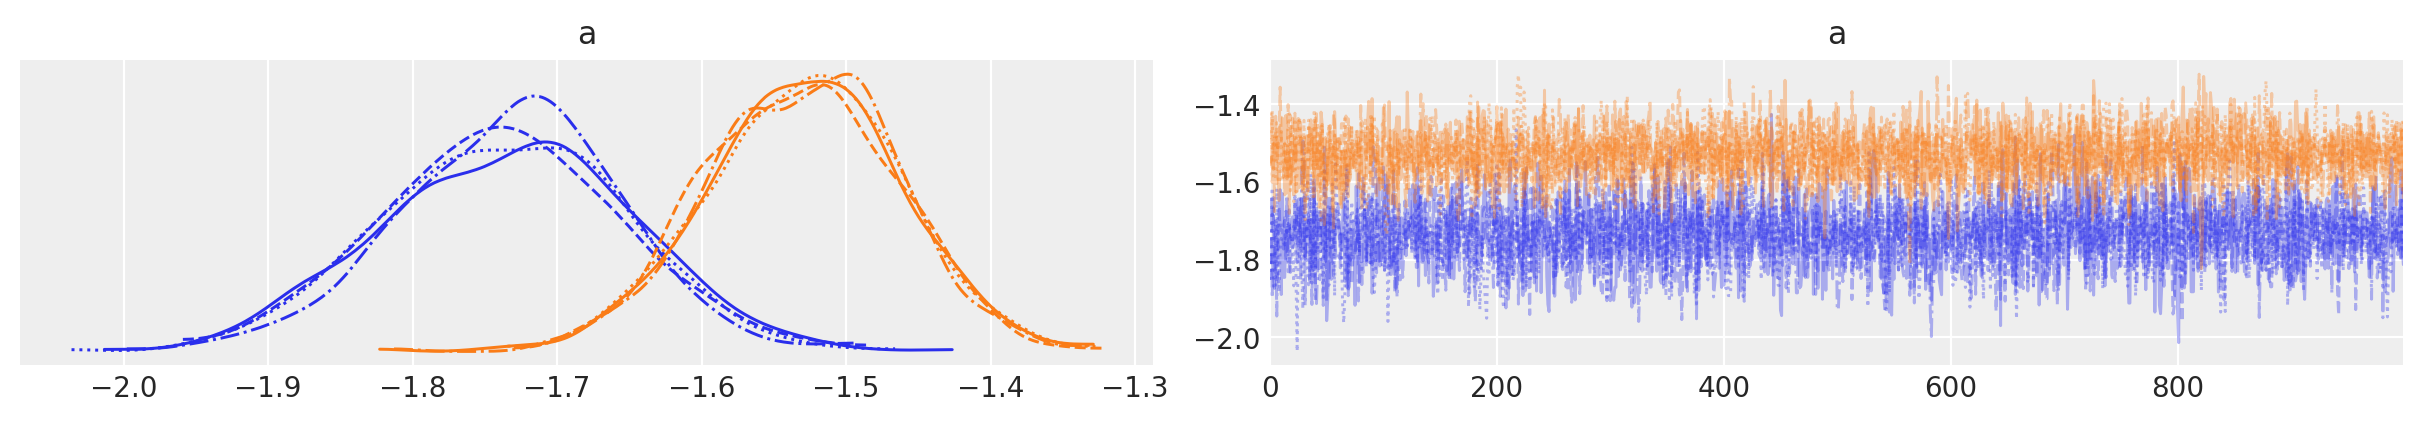

In [ ]:
az.plot_trace(t1)

In [10]:
az.summary(t1, round_to=2, kind="stats")

ValueError: Too few elements for interval calculation. 

In [11]:
samples = az.extract(t1)

In [12]:
p0 = pm.math.invlogit(samples.a[0].values).eval()
p1 = pm.math.invlogit(samples.a[1].values).eval()

In [13]:
c = p0 - p1

array([[<Axes: title={'center': 'x'}>]], dtype=object)

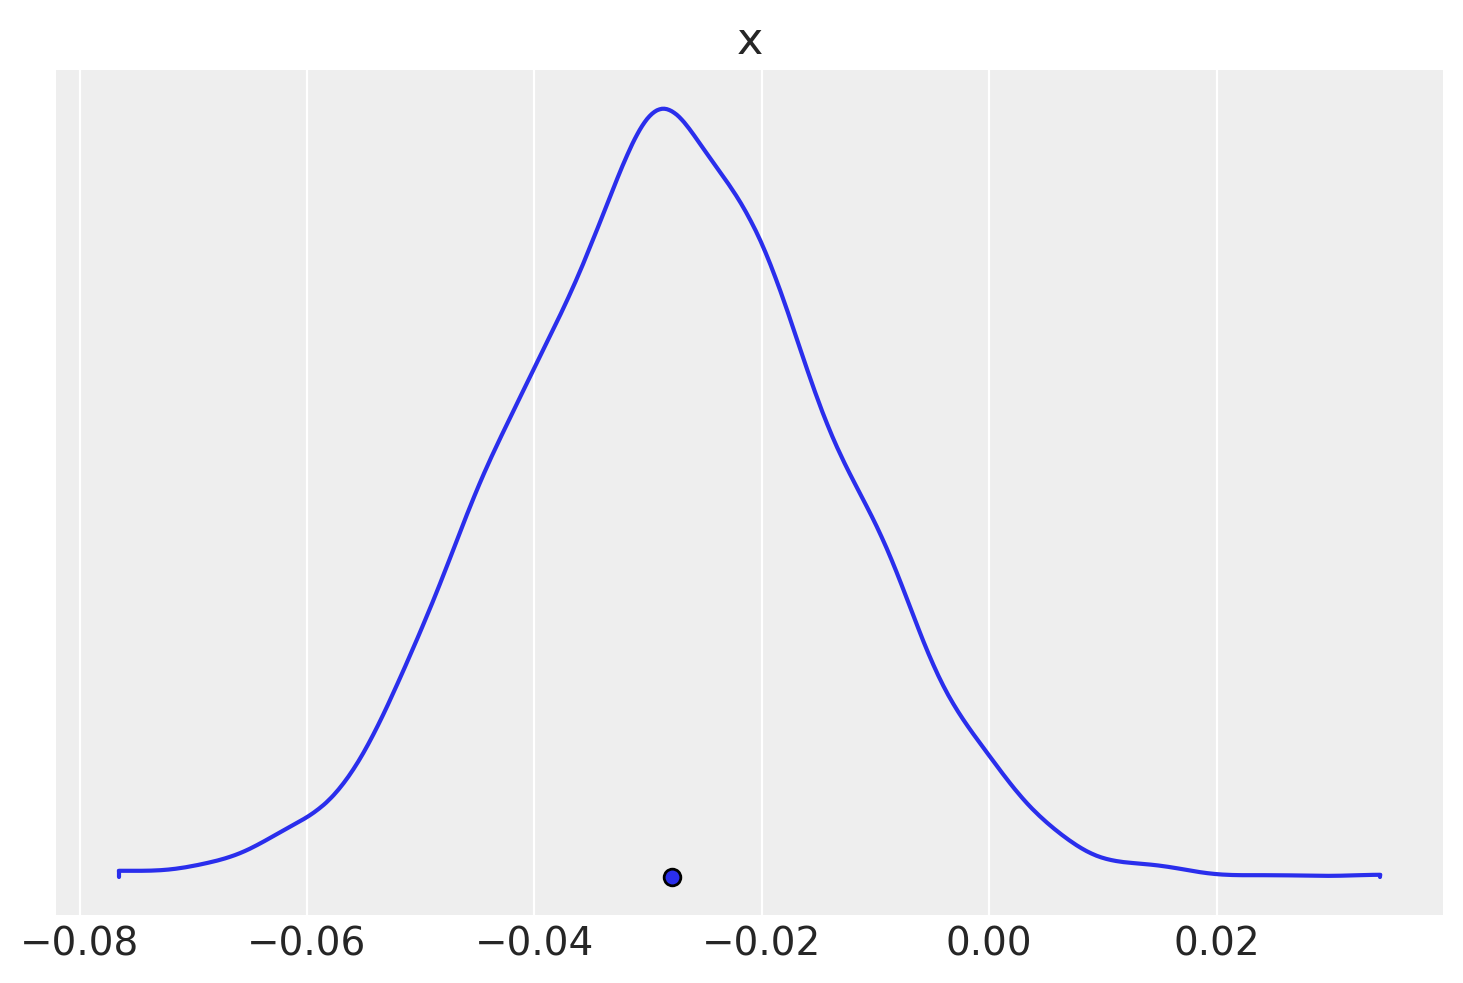

In [14]:
az.plot_density(np.array(c), hdi_prob=1.0)

2\. Now estimate the DIRECT causal effect of gender on grant awards.Use the same DAG as above to justify one or more binomial models. Compute the average direct causal effect of gender, weighting each discipline in proportion to the number of applications in the sample. Refer to the marginal effect example in Lecture 9 for help.

In [15]:
with pm.Model() as m2:
    D = pm.MutableData("D", d2.discipline)
    G = pm.MutableData("G", d2.gender)
    N = pm.MutableData("N", d2.applications)
    A = pm.MutableData("A", d2.awards)
    b = pm.Normal("b", mu=0., sigma=1., shape=(2, 9))
    p =  pm.math.invlogit(b[G, D])
    A = pm.Binomial("AA", n=N, p=p, observed=A)
    t2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


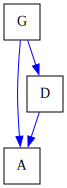

In [16]:
g = nx.DiGraph([("G", "A"), ("G", "D"), ("D", "A")])
draw(g, node_shapes="o")

In [ ]:
az.plot_trace(t2)

array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

In [24]:
num_apps = sum(d2.applications)
num_disciplines = max(d2.discipline) + 1

In [25]:
samples = az.extract(t2, num_samples=num_apps)

In [26]:
c = []
for j in range(num_disciplines):
    p0 = pm.math.invlogit(samples.b[0][j].values).eval()
    p1 = pm.math.invlogit(samples.b[1][j].values).eval()
    c.append(np.array(p0 - p1))

array([[<Axes: title={'center': 'x'}>]], dtype=object)

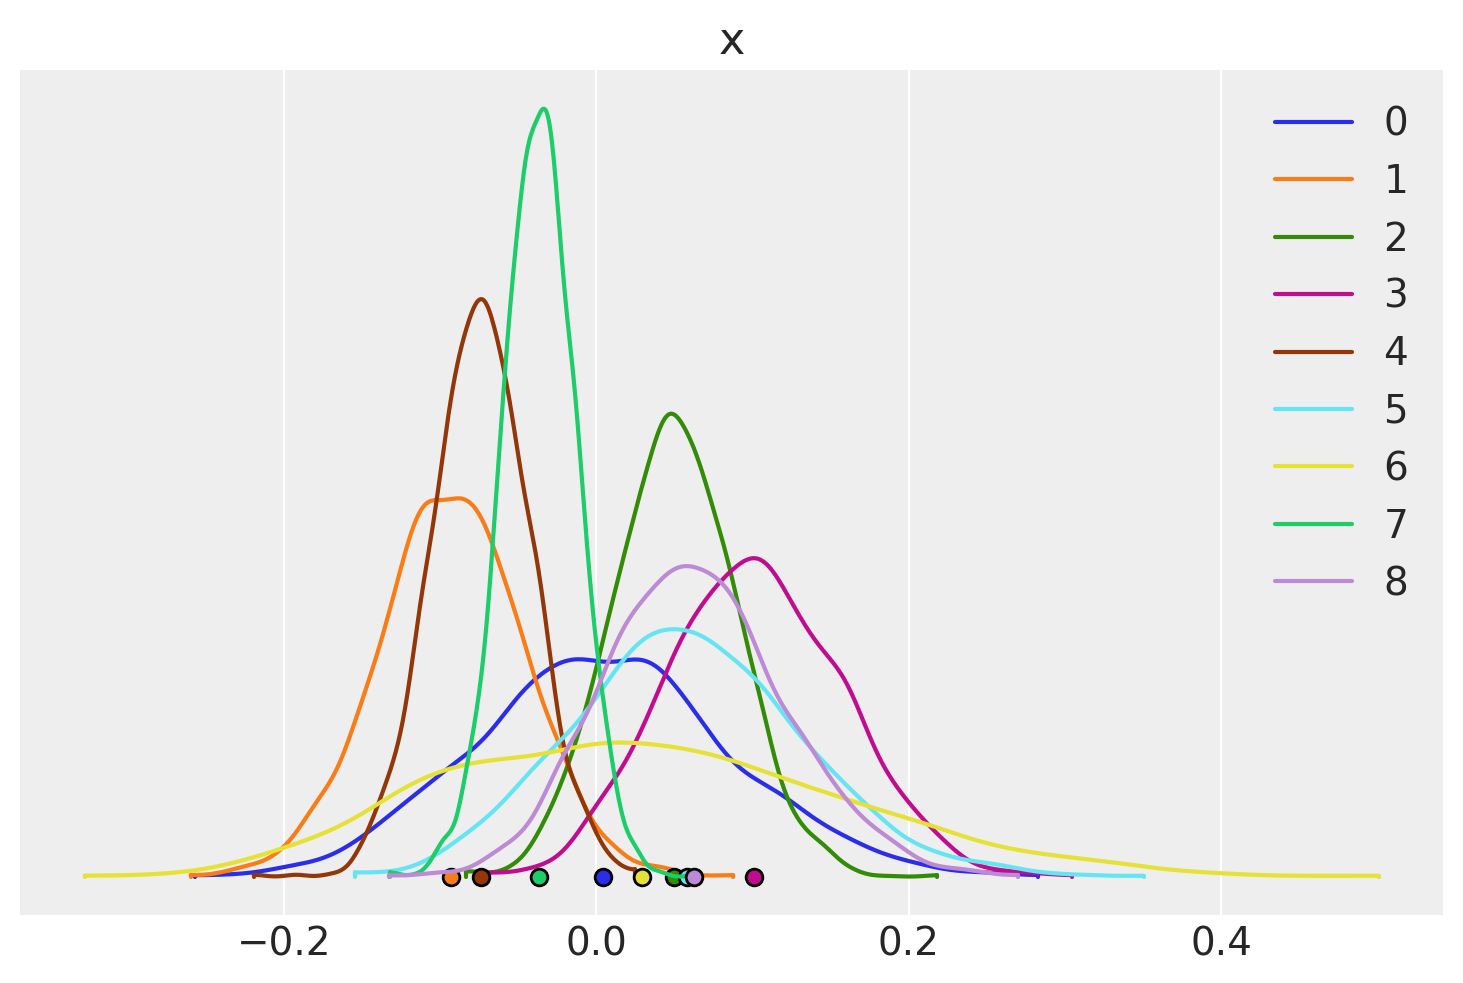

In [27]:
az.plot_density(c, hdi_prob=1.0, data_labels=d2.discipline.astype("category").cat.categories)

In [28]:
D = [None]*num_apps
N = [None]*num_apps
A = [None]*num_apps

i = 0
for d in range(0, num_disciplines):
    num_apps_per_d = sum(d2.applications[d2.discipline == d])
    for n in range(0, num_apps_per_d):
        D[i] = d
        N[i] = num_apps_per_d
        i = i + 1

In [29]:
def awards(b, n):
    logit = Logit()
    p = logit.inverse(b)
    return p

In [30]:
t2_samples = az.extract(t2, num_samples=num_apps)
num_samples = t2_samples.sizes["sample"]

In [31]:
p0 = [None]*num_apps
bs = t2_samples.b

for i in range(num_apps):
    d = D[i]
    b = bs[0][d][i].data
    n = N[i]
    p0[i] = awards(b, n)

In [32]:
p1 = [None]*num_apps
bs = t2_samples.b

for i in range(num_apps):
    d = D[i]
    b = bs[1][d][i].data
    n = N[i]
    p1[i] = awards(b, n)

In [33]:
c = np.array(p0) - np.array(p1)

array([[<Axes: title={'center': 'x'}>]], dtype=object)

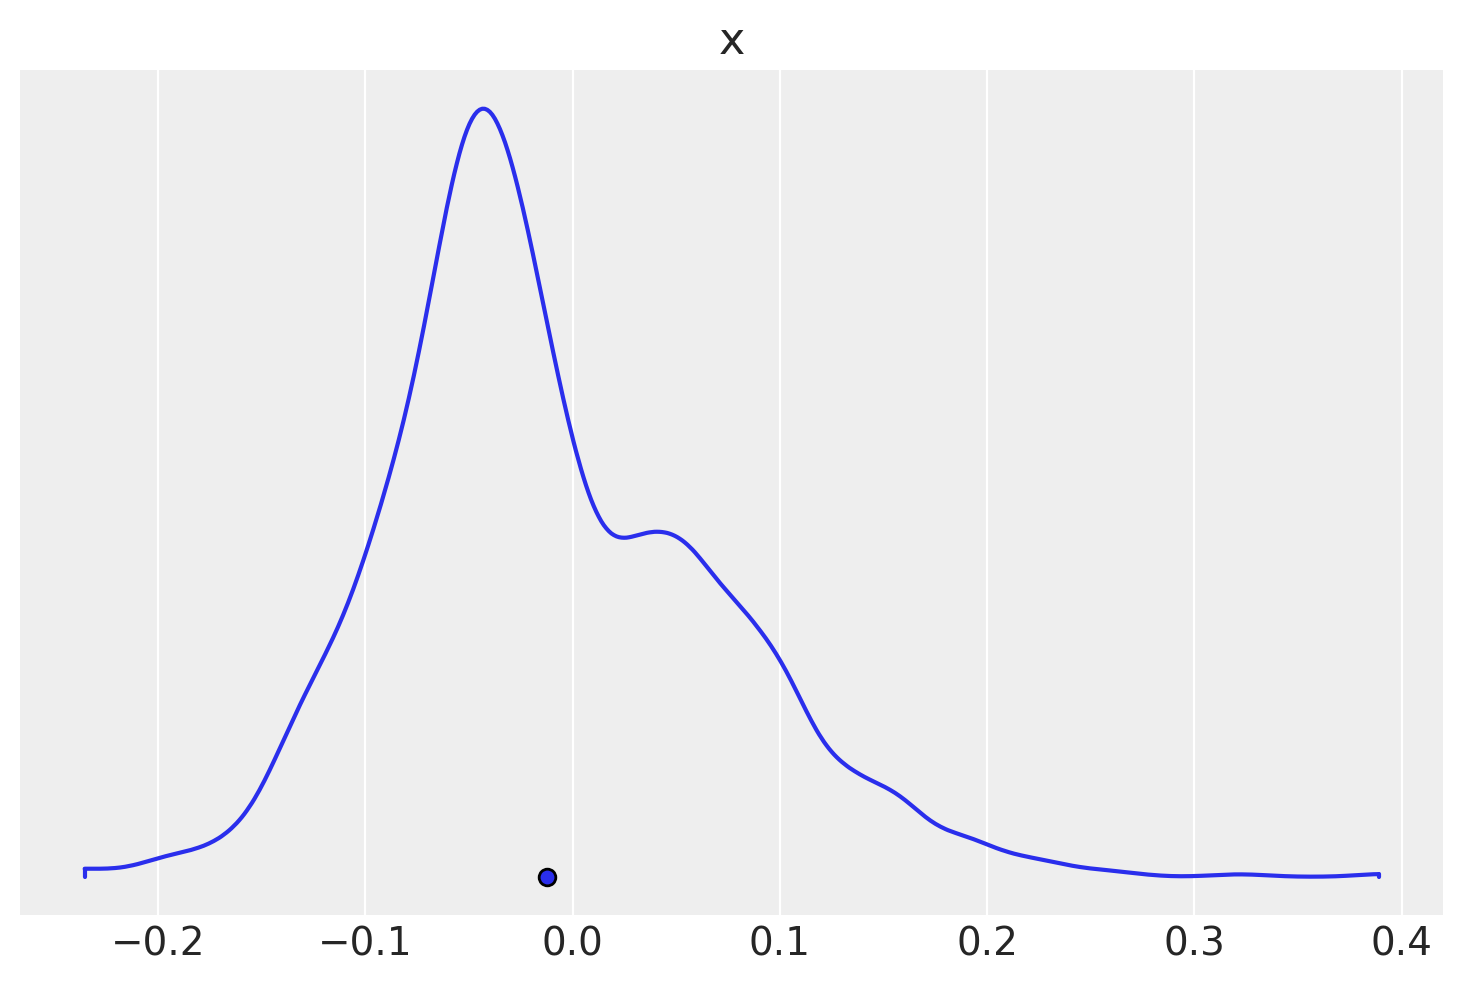

In [34]:
az.plot_density(c, hdi_prob=1.)

3\. Considering the total effect (problem 1) and direct effect (problem 2) of gender, what causes contribute to the average difference between women and men in award rate in this sample? It is not necessary to say whether or not there is evidence of dis- crimination or the presence or absence of unobserved confounds (which are likely!). Simply explain how the direct effects you have estimated make sense (or not) of the total effect.

In [35]:
d2

,discipline,gender,applications,awards
0,0,1,83,22
1,0,0,39,10
2,5,1,135,26
3,5,0,39,9
4,6,1,67,18
5,6,0,9,2
6,2,1,230,33
7,2,0,166,32
8,8,1,189,30
9,8,0,62,13


In [36]:
num_apps_f = sum(d2.applications[d2.gender == 0])
pDf = d2.applications[d2.gender == 0] / num_apps_f
num_apps_m = sum(d2.applications[d2.gender == 1])
pDm = d2.applications[d2.gender == 1] / num_apps_m

In [37]:
post = az.extract(t2)

In [38]:
logit = Logit()
pF = [logit.inverse(post.b[0][d].mean()) for d in range(num_disciplines)]
pM = [logit.inverse(post.b[1][d].mean()) for d in range(num_disciplines)]

In [39]:
colors = ["red" if x[0] > x[1] else "blue" for x in zip(pDf, pDm)]
labels = ["F" if x[0] > x[1] else "M" for x in zip(pF, pM)]

Text(0, 0.5, 'pDm')

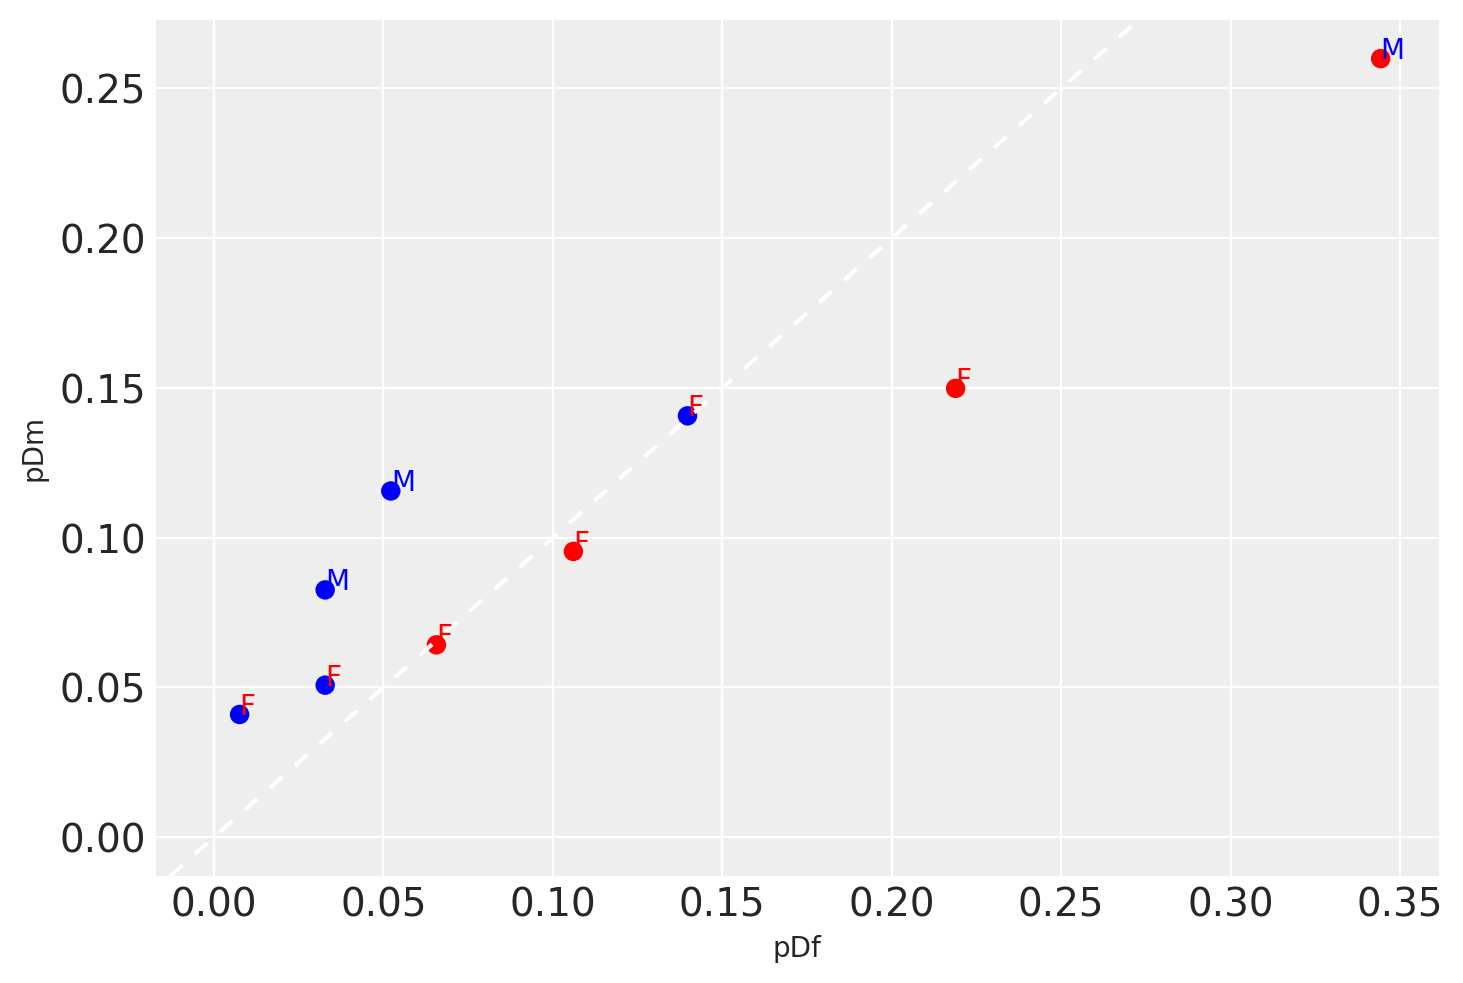

In [40]:
plt.scatter(pDf, pDm, color=colors)
text_colors = ["red" if x[0] > x[1] else "blue" for x in zip(pF, pM)]
for i, label in enumerate(labels):
    plt.text(pDf.values[i], pDm.values[i], label, c=text_colors[i])
plt.axline((0, 0), slope=1, color="white", dashes=(4, 4))
plt.xlabel("pDf")
plt.ylabel("pDm")

4-OPTIONAL CHALLENGE. The data in data(UFClefties) are the outcomes of 205 Ultimate Fighting Championship (UFC) matches (see ?UFClefties for de- tails). It is widely believed that left-handed fighters (aka “Southpaws”) have an ad- vantage against right-handed fighters, and left-handed men are indeed over-rep- resented among fighters (and fencers and tennis players) compared to the general population. Estimate the average advantage, if any, that a left-handed fighter has against right-handed fighters. Based upon your estimate, why do you think left- handers are over-represented among UFC fighters?